# Simulate some data to test the method.

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model, sigma, calc_rossby_number

bands = ["B", "V", "J", "H", "K", "BP", "RP", "G"]
mist = MIST_Isochrone(bands)
mist.initialize()

Draw randomly from mass, age, metallicity, distance and extinction distributions. Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [40]:
def generate_df(N=1000):
    """
    Simulate stellar properties from an distribution of EEPss, ages, 
    metallicities, distances and extinctions.
    """

    np.random.seed(42)
    eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
    age = np.random.uniform(8, 10.14, size=N
    age_err = .2
    feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
    mass = mist.interp_value([eep, age, feh], ["mass"])
    d_kpc = np.random.uniform(.01, 1, size=N)
    dkpc_err = d_kpc*.1
    d_pc = d_kpc*1e3
    dpc_err = d_pc*.1
    av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

    # Save as a pandas data frame
    df = pd.DataFrame(dict({"eep": eep, "eep_err": eep_err,
                            "age": age, "age_err": age_err,
                            "feh": feh, "feh_err": feh_err,
                            "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                            "Av": av, "Av_err": av_err}))
    
    logg, teff, feh_interp, B, V, J, H, K, BP, RP, G, logL = [np.zeros(N) for i in range(12)]
    print("Calculating stellar parameters...")
    for i in trange(N):
        teff[i], logg[i], feh_interp[i], bands = mist.interp_mag(
            [eep[i], age[i], feh[i], d_pc[i], av[i]], 
            ["B", "V", "J", "H", "K", "BP", "RP", "G"])
        B[i], V[i], J[i], H[i], K[i], BP[i], RP[i], G[i] = bands
        logL[i] = mist.interp_value([eep[i], age[i], feh[i]], ["logL"])[0]
    
    df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"] = B - V, B, V, J, H, K
    df["BP"], df["RP"], df["G"] = BP, RP, G
    df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
    df["mass"] = mist.mass(df.eep, df.age, df.feh)
    
    # Calculate periods. NaNs will appear for stars with B-V < 0.45
    np.random.seed(42)
    log_prot, prot_err = [np.empty(N) for i in range(2)]
    period_uncertainty = .05
    print("Calculating rotation periods...")
    for i in trange(N):
        log_prot[i] = gyro_model_rossby(df.age.values[i], df.BV.values[i], 
                                    df.mass.values[i], rossby=True, Ro_cutoff=2.16)
        prot_err[i] = (10**log_prot[i])*period_uncertainty
    
    # Add variance to these.
    sig = sigma(df.BV.values, df.eep.values)
    scatter = np.random.randn(len(log_prot))*sig
    log_prot_scatter = log_prot + scatter
    
    df["prot"] = 10**log_prot_scatter
    df["prot_clean"] = 10**log_prot
    df["prot_err"] = prot_err
    df["Ro"] = calc_rossby_number(df.prot, df.mass)

    # Cut unphysical masses
    finite_mask = np.isfinite(df.mass.values)
    finite_df = df.iloc[finite_mask]
    print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")
    
    return finite_df

In [41]:
df = generate_df(1000)

100%|██████████| 1000/1000 [00:00<00:00, 39745.51it/s]

Calculating stellar parameters...
Calculating rotation periods...
1000 stars originally,  841 after cuts


Plot the simulated data on an HR diagram.

Text(0, 0.5, '$\\log(g)$')

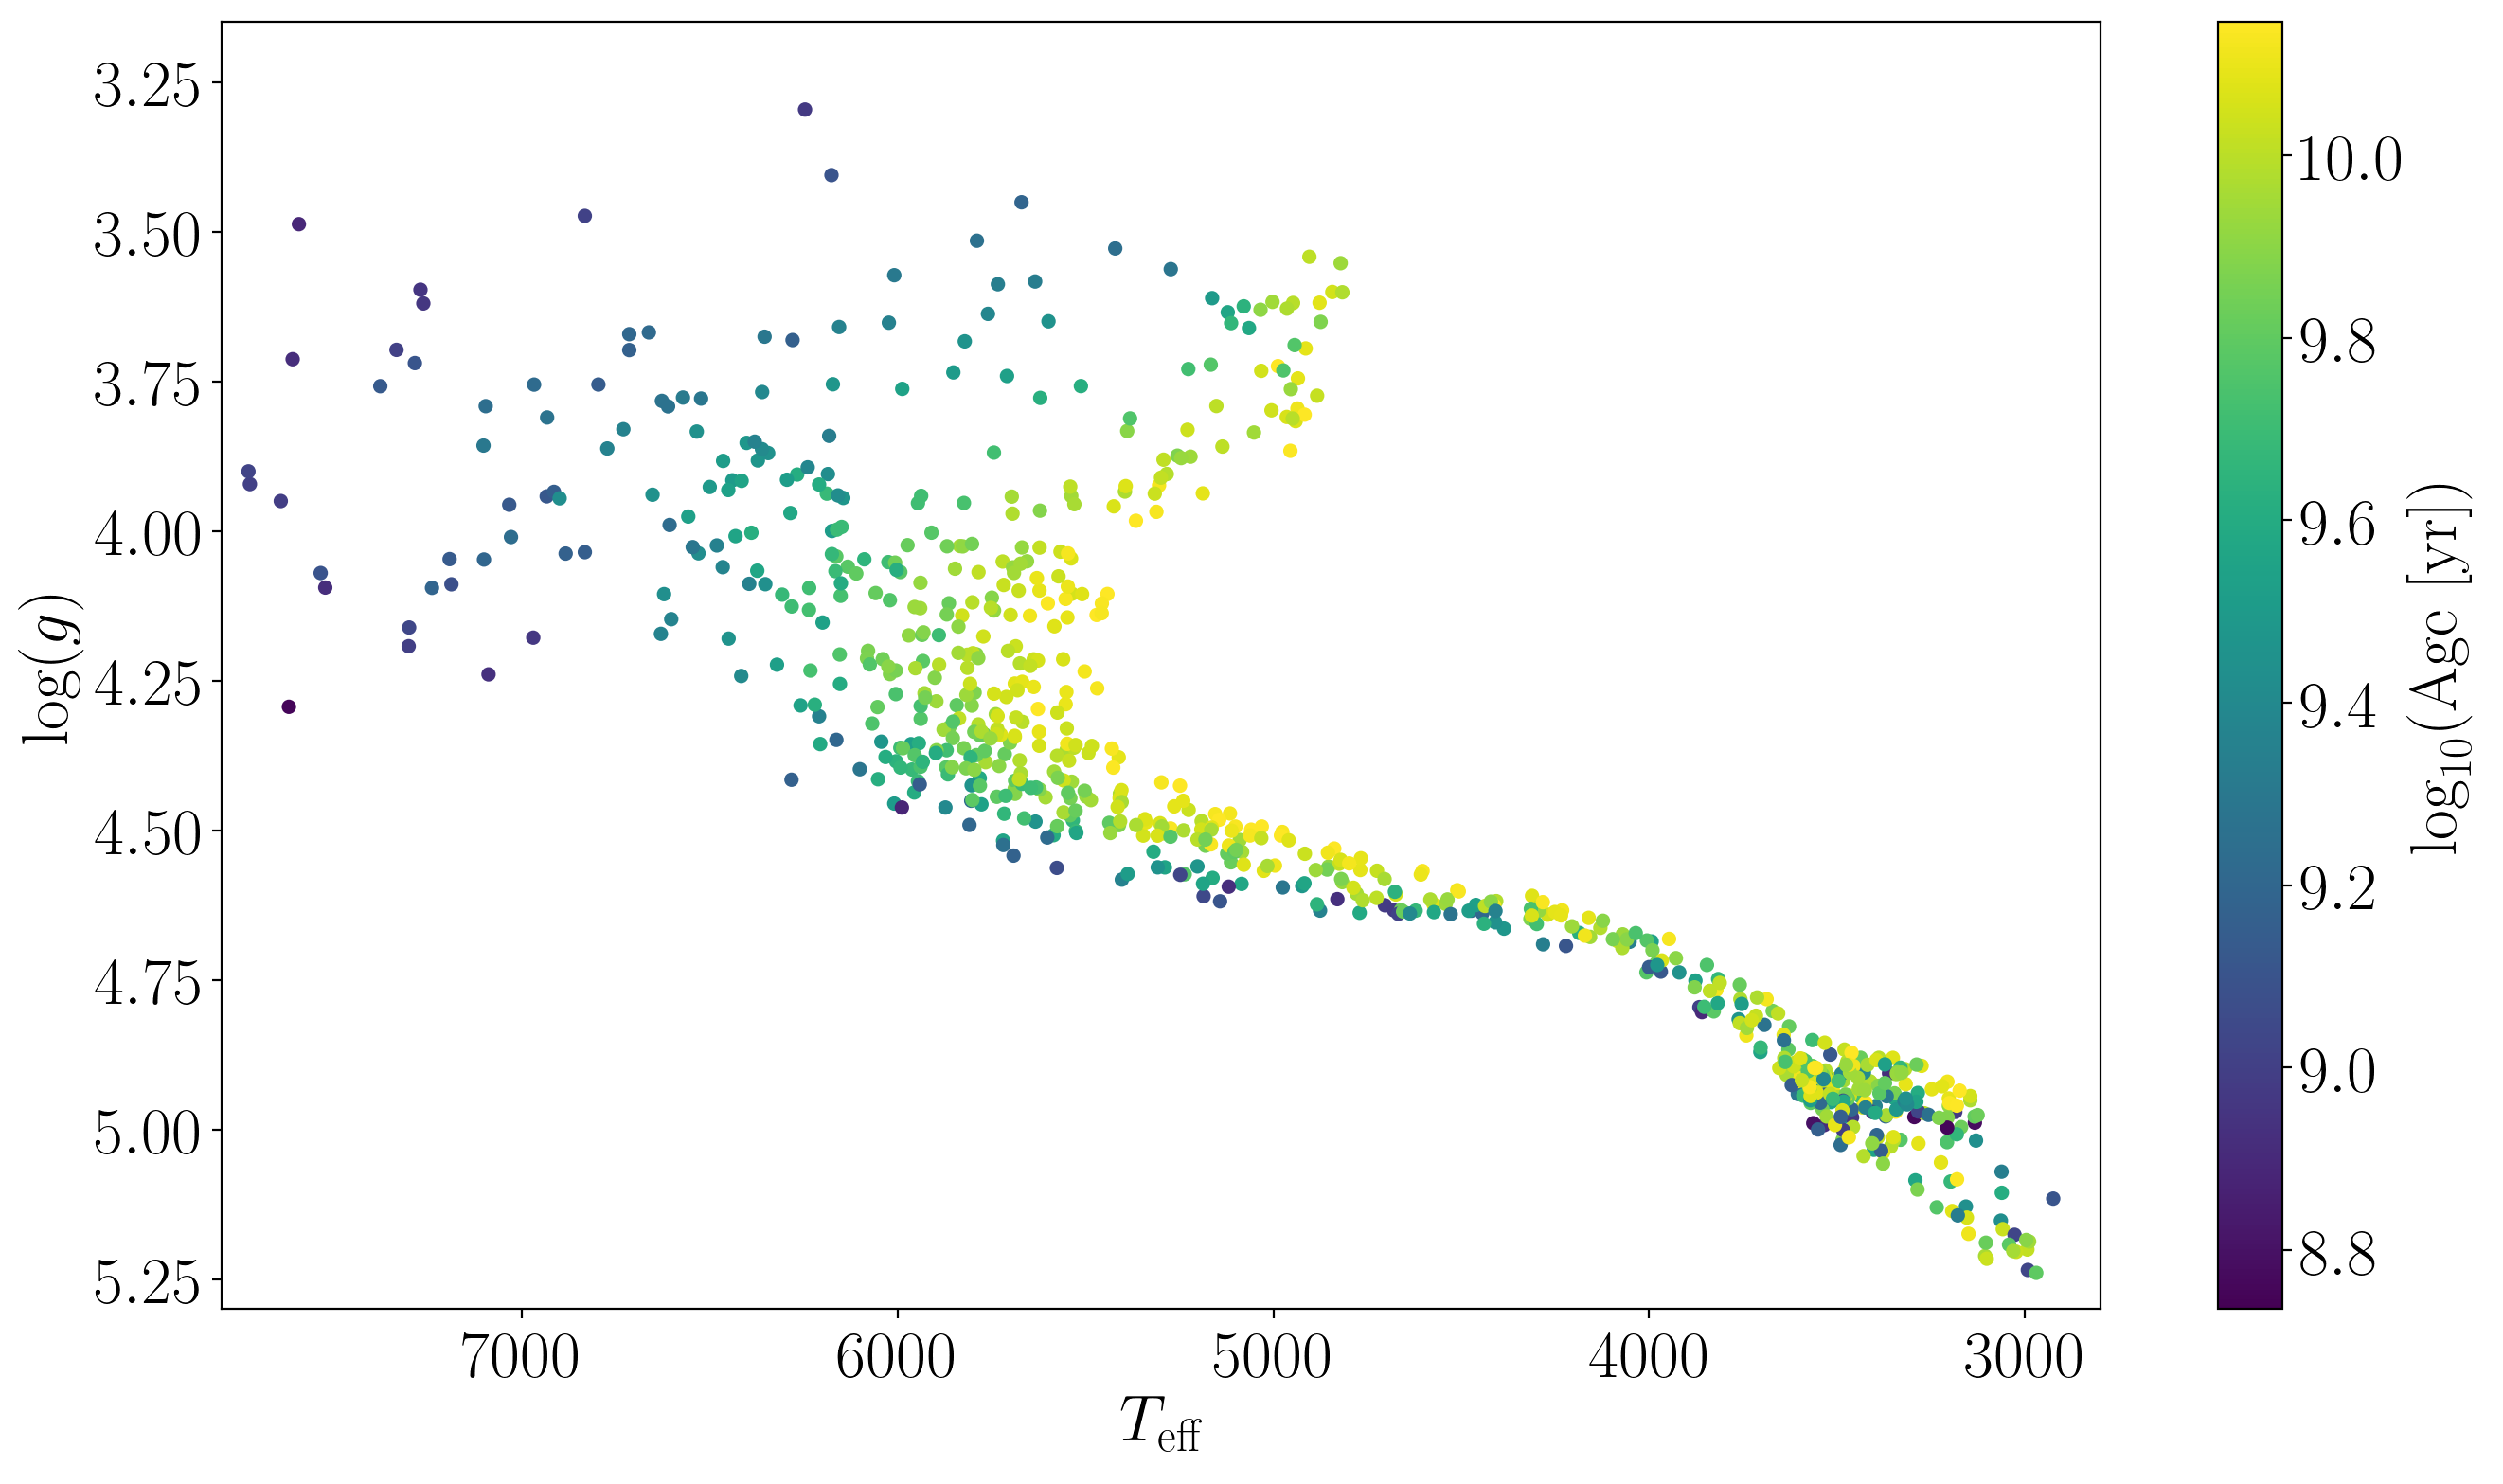

In [42]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Define functions for plotting gyrochrones. These won't include the Rossby number dependence.

In [43]:
def gyro_rot(log_age_yr, bv):
    age_myr = (10**(log_age_yr))*1e-6
    a, b, c, n = [.4, .31, .45, .55]
    return age_myr**n * a * (bv - c)**b

def gyro_age(period, bv):
    a, b, c, n = [.4, .31, .45, .55]
    return np.log10(((period/(a*(bv-c)**b))**(1./n))*1e6)

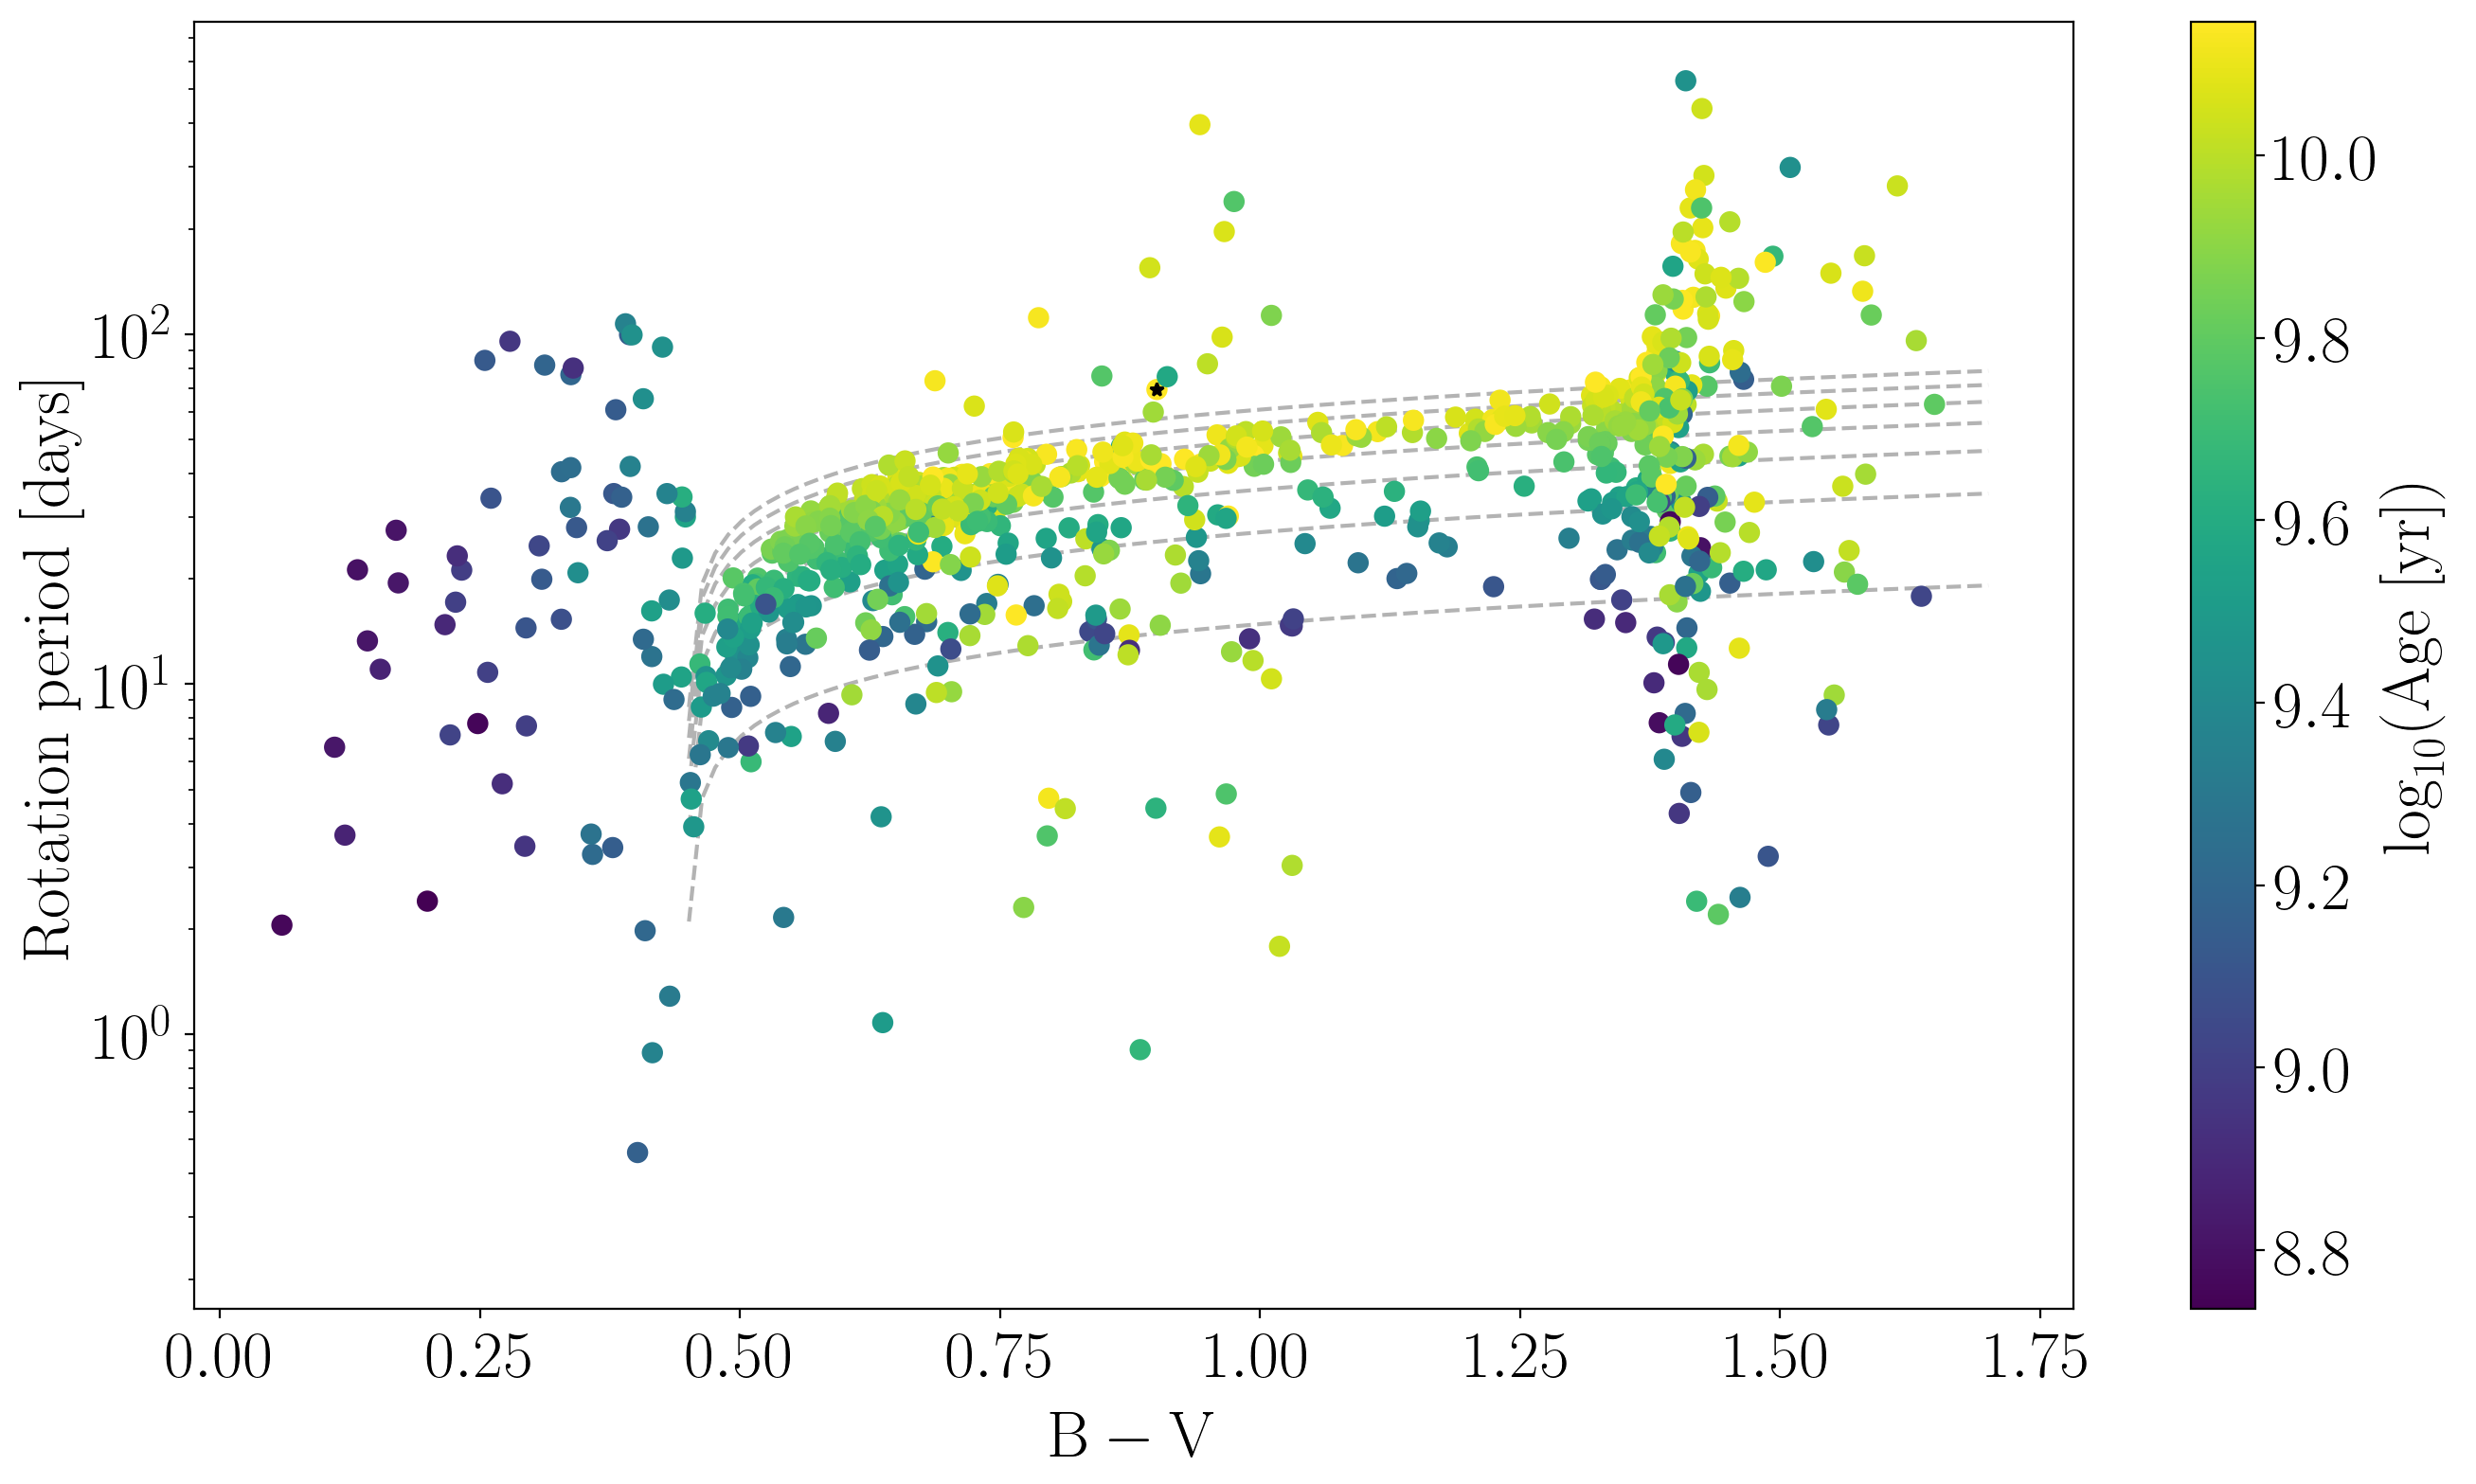

In [44]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.451, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.age, s=50, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.plot(finite_df.BV[11], finite_df.prot[11], "k*", ms=5)
plt.yscale("log")

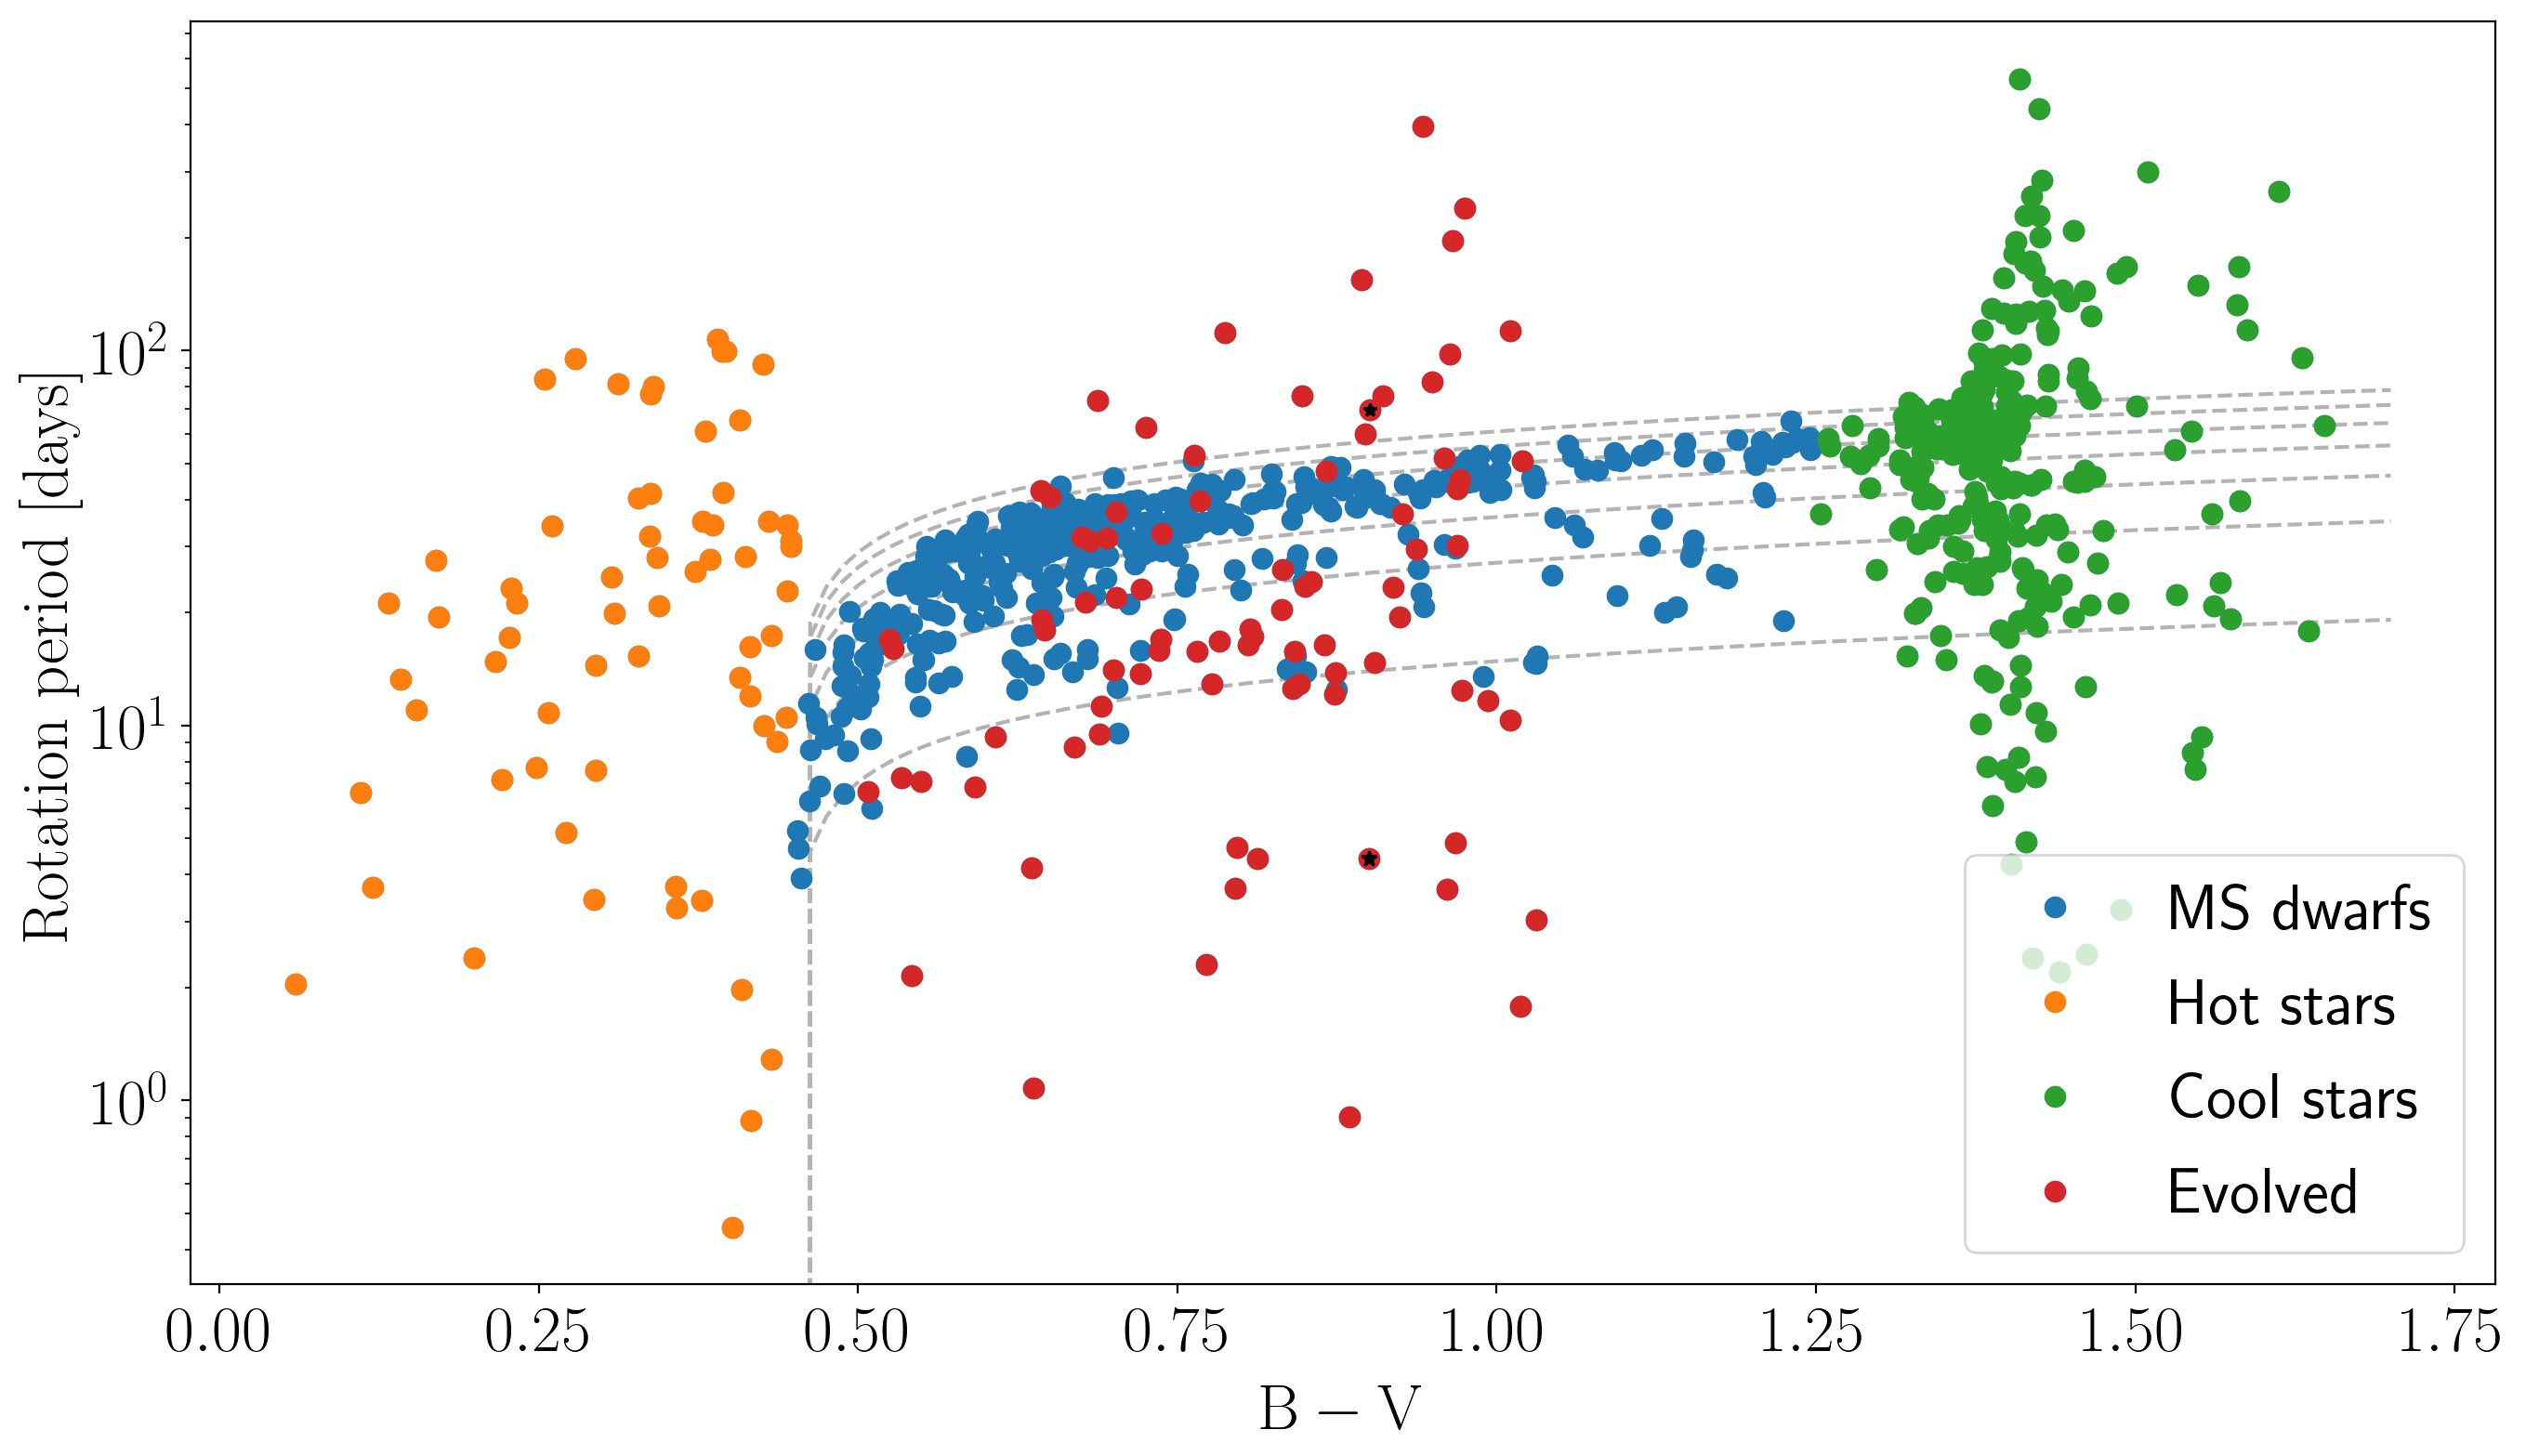

In [49]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.45, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

hot_mask = finite_df.BV < .45
cool_mask = 1.25 < finite_df.BV
evolved_mask = (.45 < finite_df.BV) * (454 < finite_df.eep)

plt.plot(finite_df.BV, finite_df.prot, ".", ms=15 , zorder=0, label="MS dwarfs")
plt.plot(finite_df.BV[hot_mask], finite_df.prot[hot_mask], ".", ms=15 , zorder=1, label="Hot stars")
plt.plot(finite_df.BV[cool_mask], finite_df.prot[cool_mask], ".", ms=15 , zorder=1, label="Cool stars")
plt.plot(finite_df.BV[evolved_mask], finite_df.prot[evolved_mask], ".", ms=15, zorder=1, label="Evolved")
plt.legend()
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.plot(finite_df.BV[11], finite_df.prot[11], "k*", ms=5)
plt.yscale("log")
plt.plot(finite_df.BV[69], finite_df.prot[69], "k*")

Save simulated data file.

In [46]:
df["ID"] = range(len(df))
df.to_csv("data/simulated_data.csv")

In [47]:
large_df = generate_df(1000000)

  0%|          | 1506/1000000 [00:00<01:06, 15053.98it/s]

Calculating stellar parameters...


  1%|          | 8233/1000000 [00:00<00:23, 41415.67it/s]

Calculating rotation periods...


100%|██████████| 1000000/1000000 [00:23<00:00, 42338.84it/s]


1000000 stars originally,  858172 after cuts


(0, 60)

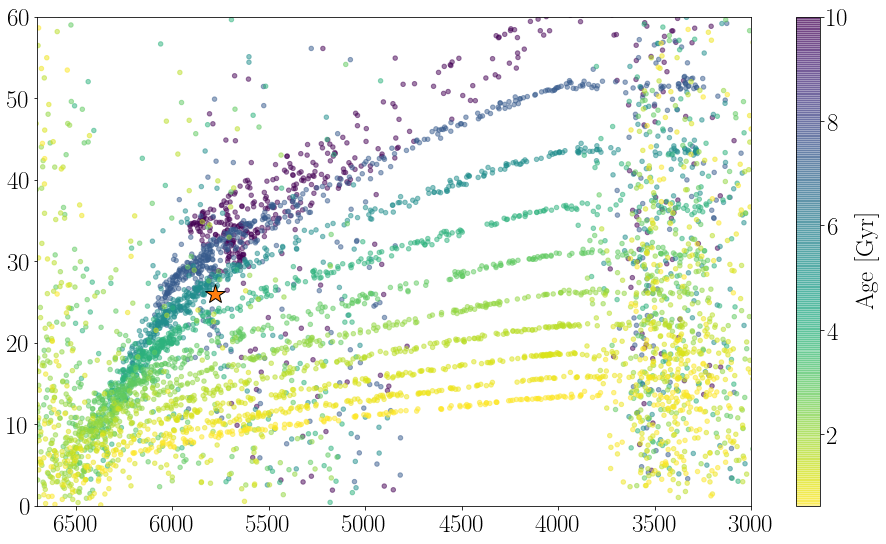

In [48]:
plt.figure(figsize=(16, 9))

def gyr(log10_age):
    return (10**log10_age)*1e-9

for i in np.linspace(10, 8.8, 10):
    m = (gyr(i) < gyr(large_df.age)) * (gyr(large_df.age) < gyr(i) + .01)
    plt.scatter(large_df.teff[m], 10**np.log10(large_df.prot[m]), c=gyr(large_df.age)[m],
                vmin=gyr(8.8), vmax=10, s=20, alpha=.5, cmap="viridis_r", rasterized=True)
plt.colorbar(label="$\mathrm{Age~[Gyr]}$")

# Sun
# plt.scatter(5778, 26, facecolors='none', edgecolors="w", s=150, zorder=3)
# plt.plot(5778, 26, ".w", zorder=3)

plt.plot(5779, 26, "*", color="C1", markeredgecolor="k", ms=20)
plt.xlim(6700, 3000)
plt.ylim(0, 60)